1. Realize uma análise exploratória da base com o objetivo de conhecer o perfil do consumidor. Retorne pelo menos, os seguintes insights: histograma da frequência de compra; Ticket Médio da base; Cohort de tempo de atividade/churn; top 5 combinações de produtos vendidos juntos;



2. No mês que vem, será lançada uma nova linha – sabores autênticos da Amazônia – que engloba, entre outros produtos, a Barra de Cacau Amazônico 70% e o Quebra quebra de Jaca com Pimenta Baniwa 70%. Crie uma segmentação com pelo menos 50 clientes mais propensos a comprarem os novos produtos;


3. Descreva seu raciocínio, métodos e ferramentas utilizadas nas análises. No caso das segmentações, descreva como as tornaria automatizadas para consumo do time de CRM em campanhas.


### Planejamento da Solução

1. Realizar análise exploratória dos dados
- plotar medidas principais da base:
- Faturamento Total: Texto
- Ticket Médio: Texto
- Faturamento Mensal: Grafico de Colunas
- Distribuição Mensal da Quantidade de Vendas: Gráfico de Colunas
- plotar um Histograma com a distribuição de frequência de compras
- Plotar uma análise Cohort dos clientes: Heatmap
- Plotar as top 5 combinações do produtos vendidos juntos (data Analysis/Apriori)

2. Identificar clientes
- Identificar Produtos que tenham semelhanças com os novos lançamentos (chocolates amargos (70%+ Cacau))
- Identificar clientes que já compraram este produto e listar 50 possíveis clientes: Arquivo CSV com a listagem de clientes

3. Descrição do Raciocíneo
- Descrever a segmentação de clientes e produtos, com as ferramentas utilizadas
- Descrever um modelo de ML que rode periódicamente a base de dados seguimentando clientes e produtos, recomendando uns aos outros

### Ferramentas

- Python 3.8.13
- VSCode com Jupyter Notebook
- Biblioteca Pandas, seaborn, matplotlib e demais
- Possibilidade de usar o Streamlit/Panel como forma de apresentar os dados e insights

### 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from itertools import combinations
from collections import Counter
import calendar
import math
import sys
import warnings
from sklearn.cluster import KMeans
if sys.warnoptions:
    warnings.simplefilter('ignore')

### 0.1 Variáveis auxiliares

In [2]:
today = dt.datetime(2022,9,30) #evitar distância temporal exceciva da base de dados

### 0.2 Import data

In [3]:
# Import data
data = pd.read_excel('datasets/chocolates_base.xlsx')

### 1. Exploratory data Analysis

In [4]:
# data Overview
data.head()

,Origem,ID Compra,Data,Cliente,Quantidade SKU,ID_SKU,Valor Unitário SKU,Valor Total SKU,Valor Total da Compra
0,Marketplace,1214290153035-01,2022-03-01 10:02:33Z,Cliente 1,1,6173,54.9,54.9,125.7
1,Marketplace,1214290153035-01,2022-03-01 10:02:33Z,Cliente 1,1,5188,54.9,54.9,125.7
2,Marketplace,1214790410357-01,2022-03-03 12:06:50Z,Cliente 2,1,5725,54.9,54.9,183.8
3,Marketplace,1214790410357-01,2022-03-03 12:06:50Z,Cliente 2,1,5447,74.0,74.0,183.8
4,Marketplace,1214790410357-01,2022-03-03 12:06:50Z,Cliente 2,1,5186,54.9,54.9,183.8


In [5]:
# Verificando Informações sobre os dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29631 entries, 0 to 29630
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Origem                 29631 non-null  object 
 1   ID Compra              29631 non-null  object 
 2   Data                   29631 non-null  object 
 3   Cliente                29631 non-null  object 
 4   Quantidade SKU         29631 non-null  int64  
 5   ID_SKU                 29631 non-null  int64  
 6   Valor Unitário SKU     29631 non-null  float64
 7   Valor Total SKU        29631 non-null  float64
 8   Valor Total da Compra  29631 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
cols = [x.lower() for x in data.columns]
cols = [x.replace(r" ", '_') for x in cols]
cols = [x.replace(r"á", 'a') for x in cols]
data.columns = cols
data.columns

Index(['origem', 'id_compra', 'data', 'cliente', 'quantidade_sku', 'id_sku',
       'valor_unitario_sku', 'valor_total_sku', 'valor_total_da_compra'],
      dtype='object')

In [7]:
# correct data types
data['data'] = pd.to_datetime(data['data']).dt.strftime('%Y-%m-%d')
data['data'] = pd.to_datetime(data['data'])
data['id_sku'] = data['id_sku'].astype(object)

In [8]:
data['origem'].value_counts()

Marketplace    29621
Fulfillment       10
Name: origem, dtype: int64

In [9]:
data[data['origem'] == 'Fulfillment']

,origem,id_compra,data,cliente,quantidade_sku,id_sku,valor_unitario_sku,valor_total_sku,valor_total_da_compra
9374,Fulfillment,MLB-41269615622,2022-03-29,Cliente 3605,2,5188,54.9,109.8,134.8
9377,Fulfillment,MLB-41271157724,2022-03-29,Cliente 3608,1,5188,54.9,54.9,79.9
9379,Fulfillment,MLB-41289595502,2022-06-14,Cliente 3608,1,5188,54.9,54.9,79.9
9381,Fulfillment,MLB-41302726702,2022-06-14,Cliente 3608,1,5188,54.9,54.9,79.9
9384,Fulfillment,MLB-41459231988,2022-06-20,Cliente 3612,1,5188,54.9,54.9,79.9
9385,Fulfillment,MLB-41459426405,2022-06-20,Cliente 3612,1,5188,54.9,54.9,79.9
9386,Fulfillment,MLB-41462160508,2022-06-21,Cliente 3612,1,5188,54.9,54.9,79.9
9387,Fulfillment,MLB-41508581036,2022-07-12,Cliente 3613,1,5188,56.9,56.9,81.9
9388,Fulfillment,MLB-41561126194,2022-08-04,Cliente 1539,1,5188,56.9,56.9,81.9
9389,Fulfillment,MLB-41621557692,2022-08-30,Cliente 3614,1,5188,56.9,56.9,81.9


In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
quantidade_sku,29631.0,1.495393,3.308480,1.0,1.00,1.00,1.0,257.0
valor_unitario_sku,29631.0,72.501374,52.400138,3.9,49.90,56.90,95.8,398.6
valor_total_sku,29631.0,85.321412,104.282924,0.0,45.52,56.90,109.9,4995.0
valor_total_da_compra,29631.0,234.372139,235.038255,0.0,124.20,190.36,269.8,5272.0


### 1.1 Feature Engineering

In [11]:
# Novas Colunas

# Coluna mes
data['mes'] = data['data'].dt.month

# Coluna nome_mes
data['nome_mes'] = data['data'].apply( lambda x: calendar.month_name[x.month])

In [12]:
# Criando datasets auxiliares

# Produtos
produtos = data[[ 'id_sku', 'valor_unitario_sku']].drop_duplicates(subset='id_sku', keep='first').reset_index(drop=True)

# Vendas
vendas = data[[ 'id_compra', 'data', 'mes', 'cliente', 'valor_total_da_compra']].drop_duplicates(subset='id_compra', keep='first').reset_index(drop=True)

In [13]:
# Exportando datasets

produtos.to_csv('datasets/produtos.csv', index=False)
vendas.to_csv('datasets/vendas.csv', index=False)

In [14]:
# 1.1  Faturamento Total e Ticket Mèdio - Faturamento Total / Qtd. Vendas

faturamento_total = data[['id_compra', 'valor_total_da_compra', 'mes']].sort_values('id_compra').drop_duplicates(subset='id_compra',
                                                                                                          keep='first')['valor_total_da_compra'].sum()
ticket_medio = round(faturamento_total/data['id_compra'].unique().size, 2)

print(f'O faturamento total da base de dados foi de R${faturamento_total:,}')
print('O Ticket médio da base de dados é de R${}'.format(ticket_medio))

O faturamento total da base de dados foi de R$2,586,093.99
O Ticket médio da base de dados é de R$191.05


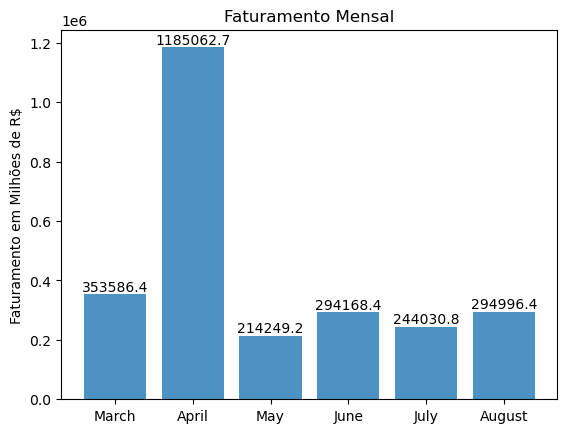

<function pandas.core.tools.datetimes.to_datetime(arg: 'DatetimeScalarOrArrayConvertible', errors: 'str' = 'raise', dayfirst: 'bool' = False, yearfirst: 'bool' = False, utc: 'bool | None' = None, format: 'str | None' = None, exact: 'bool' = True, unit: 'str | None' = None, infer_datetime_format: 'bool' = False, origin='unix', cache: 'bool' = True) -> 'DatetimeIndex | Series | DatetimeScalar | NaTType | None'>

In [15]:
# Faturamento Mensal

faturamento_mensal =  data[['id_compra', 'valor_total_da_compra', 'mes', 'nome_mes']].sort_values('id_compra').drop_duplicates(subset='id_compra',
                                                                                                          keep='first')[['valor_total_da_compra', 'mes', 'nome_mes']].groupby(['mes', 'nome_mes']).sum().reset_index()

faturamento_mensal.columns = ['mes', 'nome_mes', 'Faturamento']
mes = faturamento_mensal['nome_mes']
faturamento = faturamento_mensal['Faturamento']

#plotando o gráfico de barras verticais
g_faturamento_mensal = plt.bar(mes, faturamento, align='center', alpha=0.8) 
plt.ylabel('Faturamento em Milhões de R$')
plt.title('Faturamento Mensal')
plt.bar_label(g_faturamento_mensal, fmt="%.1f", size=10, label_type="edge")

plt.show()

pd.to_datetime

In [16]:
produto_mais_vendido = data[['quantidade_sku', 'id_sku']].groupby('id_sku').sum().sort_values('quantidade_sku', ascending=False).reset_index()['id_sku'][0]
produto_mais_vendido

5726

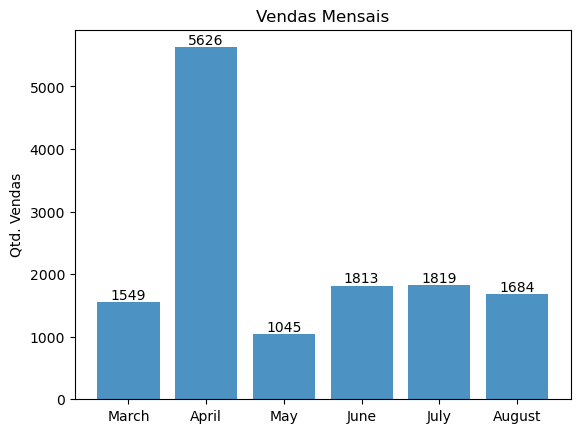

In [17]:
# Vendas Mensais

vendas_mensal =  data[['id_compra', 'valor_total_da_compra', 'mes', 'nome_mes']].sort_values('id_compra').drop_duplicates(subset='id_compra',
                                                                                                          keep='first')[['id_compra', 'mes', 'nome_mes']].groupby(['mes', 'nome_mes']).count().reset_index()

vendas_mensal.columns = ['mes', 'nome_mes', 'vendas']
vendas_mensal
mes = vendas_mensal['nome_mes']
vendas_mensais = vendas_mensal['vendas']

#plotando o gráfico de barras verticais
g_vendas_mensal = plt.bar(mes, vendas_mensais, align='center', alpha=0.8) 
plt.ylabel('Qtd. Vendas')
plt.title('Vendas Mensais')
plt.bar_label(g_vendas_mensal, fmt="%.0f", size=10, label_type="edge")

plt.show()

In [18]:
fig = px.histogram( data,
                    x=vendas[['cliente', 'id_compra']].groupby('cliente').count()['id_compra'],
                    log_y=True)
fig.show()

c:\Users\renat\anaconda3\envs\dengo_chocolates\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\renat\anaconda3\envs\dengo_chocolates\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Text(0, 0.5, 'Qtd. clientes')

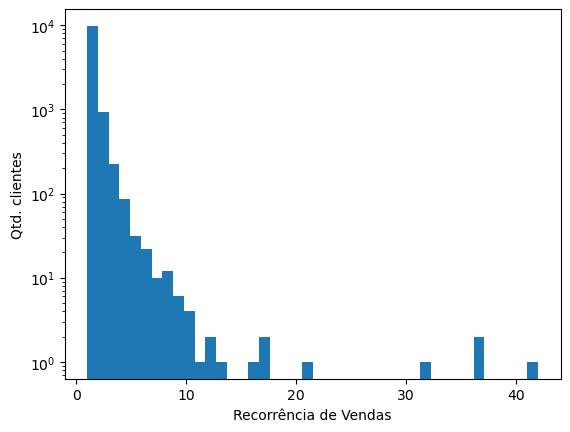

In [19]:
# Histograma de Frequencia de Compras

plt.hist(x=vendas[['cliente', 'id_compra']].groupby('cliente').count()['id_compra'], bins=42, log=True);
plt.xlabel('Recorrência de Vendas')
plt.ylabel( 'Qtd. clientes')

In [20]:
# Cohort Analysis

# Define COhort dataset
cohort = data[[ 'id_compra', 'data', 'cliente']]
cohort['data'] = cohort['data'].apply(lambda x: x.strftime('%Y-%m'))
cohort.set_index('cliente', inplace=True)
cohort['cohort'] = cohort.groupby(level=0)['data'].min()
cohort.reset_index(inplace=True)

# Get cohort clients count
cohort = cohort.groupby(['cohort', 'data'])
cohort = cohort.agg({'cliente' : pd.Series.nunique})
cohort.rename(columns={'cliente' : 'Total de clientes'}, inplace=True)

# Function to Get Cohort Period
def cohort_period(data):
    data['cohort_period'] = np.arange(len(data)) + 1
    return data

cohort = cohort.groupby(level=0).apply(cohort_period)
cohort.reset_index(inplace=True)
cohort.set_index(['cohort', 'cohort_period'], inplace=True)

cohort

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1688298760.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1688298760.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



data  Total de clientes
cohort  cohort_period                            
2022-03 1              2022-03               1390
        2              2022-04                115
        3              2022-05                 47
        4              2022-06                 67
        5              2022-07                 49
        6              2022-08                 55
2022-04 1              2022-04               4856
        2              2022-05                 91
        3              2022-06                 98
        4              2022-07                 66
        5              2022-08                 75
2022-05 1              2022-05                782
        2              2022-06                 37
        3              2022-07                 21
        4              2022-08                 30
2022-06 1              2022-06               1416
        2              2022-07                 52
        3              2022-08                 44
2022-07 1              2022-07               1458
        2              2022-08                 47
2022-08 1              2022-08               1274

In [21]:
# Getting group size for each cohort period 
cohort_group_size = cohort['Total de clientes'].groupby(level=0).first()
cohort_group_size

cohort
2022-03    1390
2022-04    4856
2022-05     782
2022-06    1416
2022-07    1458
2022-08    1274
Name: Total de clientes, dtype: int64

In [22]:
# Pivoting cohort dataset into distribuition of clients by cohort start and period
cohort_data = cohort.reset_index()
cohort_counts = cohort_data.pivot(index='cohort', 
                                   columns='cohort_period',
                                   values='Total de clientes')
cohort_counts

cohort_period,1,2,3,4,5,6
cohort,,,,,,
2022-03,1390.0,115.0,47.0,67.0,49.0,55.0
2022-04,4856.0,91.0,98.0,66.0,75.0,NaN
2022-05,782.0,37.0,21.0,30.0,NaN,NaN
2022-06,1416.0,52.0,44.0,NaN,NaN,NaN
2022-07,1458.0,47.0,NaN,NaN,NaN,NaN
2022-08,1274.0,NaN,NaN,NaN,NaN,NaN


In [23]:
# Calculating costumer retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.round(3)*100

user_retention = cohort['Total de clientes'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

cohort,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08
cohort_period,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.082734,0.018740,0.047315,0.036723,0.032236,NaN
3,0.033813,0.020181,0.026854,0.031073,NaN,NaN
4,0.048201,0.013591,0.038363,NaN,NaN,NaN
5,0.035252,0.015445,NaN,NaN,NaN,NaN
6,0.039568,NaN,NaN,NaN,NaN,NaN


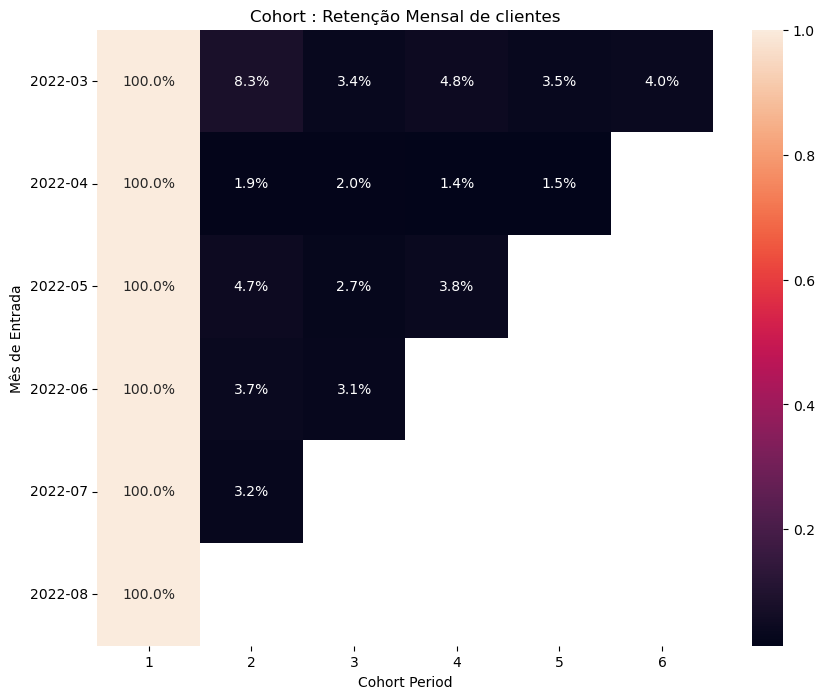

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Cohort : Retenção Mensal de clientes')
sns.heatmap(user_retention.T,
            mask=user_retention.T.isnull(),
            annot=True,
            fmt='.1%',
            ax=ax,
            square=True);
plt.xlabel('Cohort Period')
plt.ylabel('Mês de Entrada')
plt.yticks(rotation=0)
plt.show()

In [25]:
# Getting Sold Together dataset

bundle = data[data['id_compra'].duplicated(keep=False)];
bundle['id_sku'] = bundle['id_sku'].astype( str )
bundle['bundle'] = bundle.groupby('id_compra')['id_sku'].transform(lambda x: ', '.join(x));
bundle = bundle[['id_compra', 'bundle']].drop_duplicates()

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1590136456.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1590136456.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# Get Top 5 sold together
#  
count = Counter()

for row in bundle['bundle']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list,2)))

top_five = pd.DataFrame(count.most_common(5))
top_five.columns = ['combination', 'frequency'] 
top_five['combination'] = top_five['combination'].astype( str )
top_five['combination'] = top_five['combination'].str.replace(r"['''''()]","")
top_five.to_csv('datasets/bundle.csv')
top_five

top_five = pd.DataFrame(count.most_common(5))
top_five.columns = ['Combinação de Produtos', 'Qtd. Vendas'] 
top_five['Combinação de Produtos'] = top_five['Combinação de Produtos'].astype( str )
top_five['Combinação de Produtos'] = top_five['Combinação de Produtos'].str.replace(r"['''''()]","")
top_five.to_csv('datasets/bundle.csv')

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1491978412.py:12: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\1491978412.py:19: FutureWarning:

The default value of regex will change from True to False in a future version.



In [27]:
fig = px.bar(top_five.sort_values('Qtd. Vendas', ascending=True), x="Qtd. Vendas", y="Combinação de Produtos", orientation='h', text_auto='combination')
fig.show()

c:\Users\renat\anaconda3\envs\dengo_chocolates\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\renat\anaconda3\envs\dengo_chocolates\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Seguimentação de clientes

#### Análise RFM

In [28]:
# Segmentation

segmentation = data[['cliente','data','id_compra','valor_total_da_compra']]
segmentation.drop_duplicates(subset='id_compra', keep='first', inplace=True);

rfm= segmentation.groupby('cliente').agg({'data': lambda date: (today - date.max()).days,
                                        'id_compra': lambda num: len(num),
                                        'valor_total_da_compra': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm.sort_values('recency', ascending=False)

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\4173935168.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,recency,frequency,monetary
cliente,,,
Cliente 1,213,1,125.7
Cliente 8,213,1,219.6
Cliente 5,213,1,92.8
Cliente 17,213,1,151.5
Cliente 15,213,1,189.0
...,...,...,...
Cliente 3544,30,1,186.1
Cliente 3545,30,1,220.6
Cliente 3546,30,1,331.6


In [29]:
def calcular_wcss(data):
    wcss = []
    for k in range(1,10):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X=data)
        data['Clusters']=kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

In [30]:
df_recencia = rfm[['recency']]
recency_squared_sum = calcular_wcss(df_recencia)

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

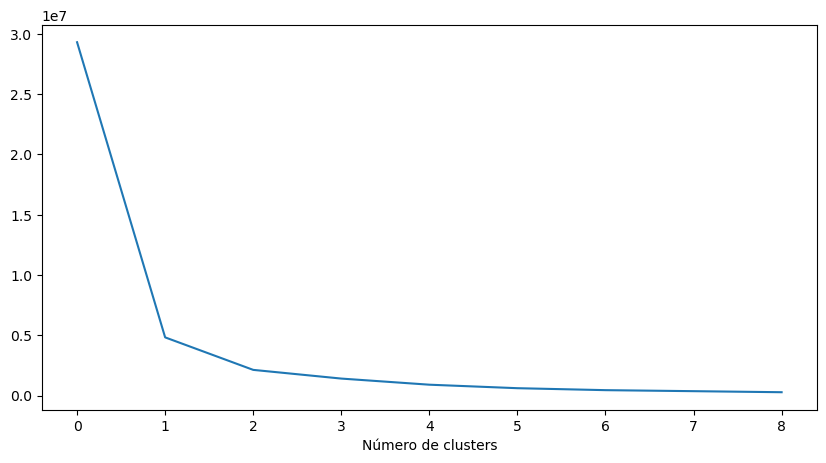

In [31]:
plt.figure(figsize=(10,5))
plt.plot(recency_squared_sum)
plt.xlabel('Número de clusters')
plt.show()

In [32]:
def numero_otimo_clusters(wcss):
    x1, y1 = 0,wcss[0]
    x2, y2 = 20,wcss[len(wcss)-1]
    
    distancia = []
    for i in range(len(wcss)):
        x0 = i
        y0 = wcss[i]
        numerador = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancia.append(numerador/denominador)
    return distancia.index(max(distancia))

In [33]:
n = numero_otimo_clusters(recency_squared_sum)
n

2

In [34]:
kmeans=KMeans(n_clusters=n)
rfm['RecenciaCluster'] = kmeans.fit_predict(df_recencia)
rfm.head()

,recency,frequency,monetary,RecenciaCluster
cliente,,,,
Cliente 1,213,1,125.7,1
Cliente 10,47,3,758.2,0
Cliente 100,207,1,138.0,1
Cliente 1000,80,1,36.9,0
Cliente 10000,115,1,159.2,0


In [35]:
def ordenador_cluster(cluster_nome,target_nome,df, ascending=True):
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    
    if ascending == True:
        agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,ascending=True).reset_index(drop=True)
    else:
        agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,ascending=False).reset_index(drop=True)

    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']],on=cluster_nome)
    removendo_dandos = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dandos.rename(columns={'index':cluster_nome})
    return df_final

In [36]:
rfm = ordenador_cluster('RecenciaCluster','recency',rfm, False)
rfm.head()

,recency,frequency,monetary,RecenciaCluster
0,213,1,125.70,0
1,207,1,138.00,0
2,207,1,187.65,0
3,207,1,202.80,0
4,190,1,439.00,0


In [37]:
rfm.groupby('RecenciaCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,6553.0,171.999390,15.362103,125.0,169.0,172.0,178.0,213.0
1,4623.0,76.975124,26.619619,30.0,53.0,79.0,100.0,124.0


In [38]:
df_frequencia = rfm[['frequency']]
frequency_squared_sum = calcular_wcss(df_frequencia)
n = numero_otimo_clusters(frequency_squared_sum)

kmeans = KMeans(n_clusters=n)
rfm['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)
rfm.head()

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster
0,213,1,125.70,0,0
1,207,1,138.00,0,0
2,207,1,187.65,0,0
3,207,1,202.80,0,0
4,190,1,439.00,0,0


In [39]:
rfm.groupby('FrequenciaCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,9832.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,1161.0,2.192937,0.394774,2.0,2.0,2.0,2.0,3.0
2,5.0,33.800000,7.981228,21.0,32.0,37.0,37.0,42.0
3,178.0,5.556180,2.381589,4.0,4.0,5.0,6.0,17.0


In [40]:
rfm = ordenador_cluster('FrequenciaCluster','frequency',rfm, True)
rfm.head()

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster
0,213,1,125.70,0,0
1,207,1,138.00,0,0
2,207,1,187.65,0,0
3,207,1,202.80,0,0
4,190,1,439.00,0,0


In [41]:

df_monetary = rfm[['monetary']]
monetary_squared_sum = calcular_wcss(df_monetary)
n = numero_otimo_clusters(monetary_squared_sum)
kmeans = KMeans(n_clusters=n)
rfm['monetaryCluster'] = kmeans.fit_predict(df_monetary)
rfm.head()



C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\renat\AppData\Local\Temp\ipykernel_10944\3053334412.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster,monetaryCluster
0,213,1,125.70,0,0,0
1,207,1,138.00,0,0,0
2,207,1,187.65,0,0,0
3,207,1,202.80,0,0,0
4,190,1,439.00,0,0,2


In [42]:
rfm = ordenador_cluster('monetaryCluster','monetary',rfm, True)
rfm .head()

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster,monetaryCluster
0,213,1,125.70,0,0,0
1,207,1,138.00,0,0,0
2,207,1,187.65,0,0,0
3,207,1,202.80,0,0,0
4,190,1,110.58,0,0,0


In [43]:
rfm.groupby('monetaryCluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
monetaryCluster,,,,,,,,
0,9134.0,151.791939,73.751938,1.95,94.200,149.795,207.0000,306.30
1,1803.0,460.596090,134.873459,306.60,350.100,419.400,546.9700,862.30
2,211.0,1265.928104,369.685479,869.10,973.250,1155.000,1454.7000,2404.90
3,28.0,3645.030000,1160.334086,2495.00,2767.375,3383.255,3833.1475,7707.42


In [44]:
rfm['Score'] = rfm['RecenciaCluster'] +rfm['FrequenciaCluster']+rfm['monetaryCluster']

In [45]:
rfm.Score.max()

7

In [46]:
rfm['Seguimento'] = rfm['Score'].apply( lambda x: 'Inativo' if x < 3 else
                                                'Baixo Valor' if x < 5 else
                                                'Medio Valor' if x < 7 else 'Alto Valor')

In [47]:
rfm.to_csv('datasets/RFM.csv')

In [48]:
rfm.sample(10)

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster,monetaryCluster,Score,Seguimento
8938,46,2,244.62,1,1,0,2,Inativo
9704,171,1,329.70,0,0,1,1,Inativo
1489,175,1,49.90,0,0,0,0,Inativo
1163,177,1,109.90,0,0,0,0,Inativo
59,190,1,109.90,0,0,0,0,Inativo
7984,87,1,117.10,1,0,0,1,Inativo
5799,78,1,140.70,1,0,0,1,Inativo
4771,137,1,116.60,0,0,0,0,Inativo
347,184,1,221.60,0,0,0,0,Inativo
2111,200,1,76.90,0,0,0,0,Inativo


In [49]:
def plot_segmento(x,y,data):
    sns.set(palette='muted',color_codes=True,style='whitegrid')
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=x,y=y,hue='Seguimento',data=data,size='Seguimento',sizes=(50,150),size_order=['Alto Valor','Medio Valor','Baixo Valor','Inativo'])

    return None

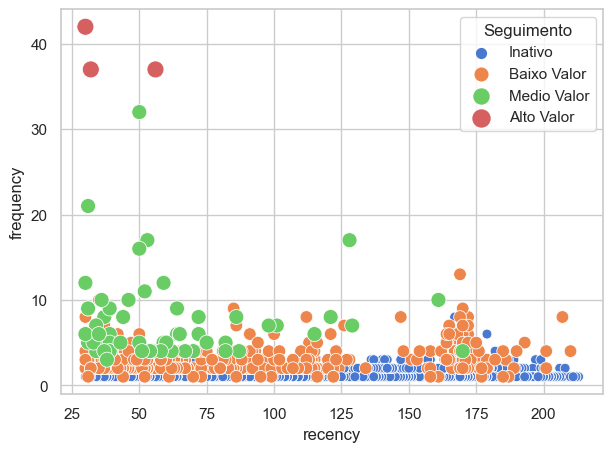

In [50]:
plot_segmento('recency','frequency',rfm)

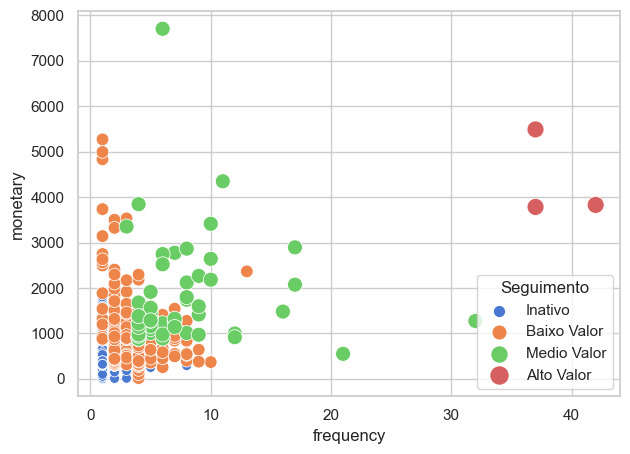

In [51]:
plot_segmento('frequency','monetary',rfm)

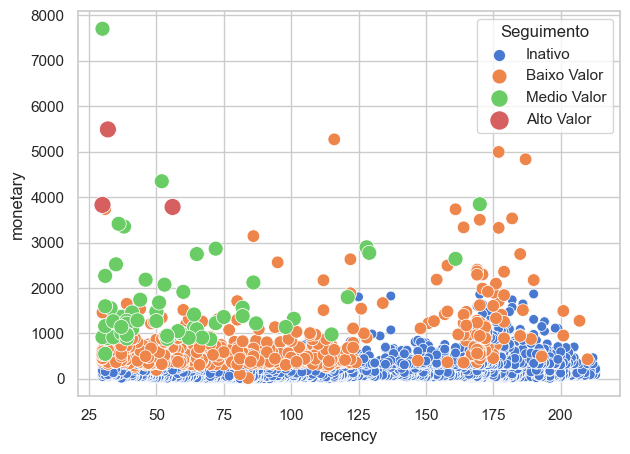

In [52]:
plot_segmento('recency','monetary',rfm)

In [53]:
rfm.Seguimento.value_counts()

Inativo        10580
Baixo Valor      532
Medio Valor       61
Alto Valor         3
Name: Seguimento, dtype: int64

In [54]:
rfm_percentual  = rfm[['Seguimento', 'recency']].groupby('Seguimento').count().reset_index()
rfm_percentual['recency'] = rfm_percentual['recency'].apply(lambda x: round(x/rfm_percentual['recency'].sum(), 3))

In [55]:
rfm_percentual

,Seguimento,recency
0,Alto Valor,0.000
1,Baixo Valor,0.048
2,Inativo,0.947
3,Medio Valor,0.005


In [56]:
rfm.head()

,recency,frequency,monetary,RecenciaCluster,FrequenciaCluster,monetaryCluster,Score,Seguimento
0,213,1,125.70,0,0,0,0,Inativo
1,207,1,138.00,0,0,0,0,Inativo
2,207,1,187.65,0,0,0,0,Inativo
3,207,1,202.80,0,0,0,0,Inativo
4,190,1,110.58,0,0,0,0,Inativo


(0.0, 11638.000000000002)

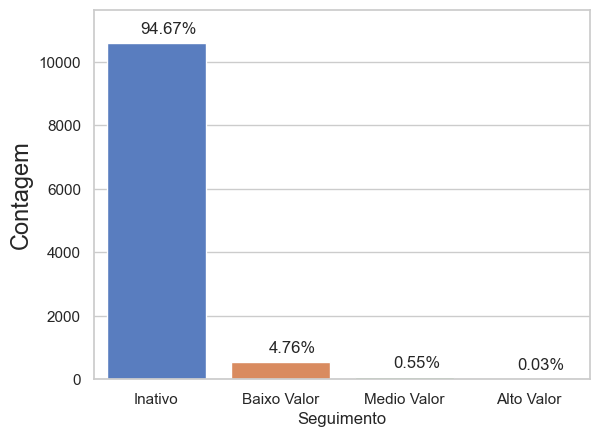

In [57]:
g = sns.countplot(x=rfm['Seguimento'])
g.set_ylabel('Contagem',fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x() + p.get_width()/1.6,
          height+200,
          '{:1.2f}%'.format(height/rfm.shape[0]*100),
          ha = 'center',va='bottom',fontsize=12)
    
g.set_ylim(0,max(sizes)*1.1)

### 4. Insights

#### 4.1 Base de Dados

- A base nao contempla dados dos clientes que permitam outros tipos de seguimentação que não pelo comportamento de compra (Análise RFM)
- A base não contempla categorização dos produtos. Embora seja possível criar um algorítimo para categorizar com base na descrição do produto, seria mais produtivo uma categorização que partisse da própria base de dados
- Uma base com mais features sobre os clientes e produtos habilitará novos insights a partir dos dados.

#### 4.2 Vendas

- O mês de maior quantidade de vendas, e por consequencia maior fatramento, é o mês de Abril, sabidamente em virtude da páscoa. É neste mês também em que ocorre a maior entrada de clientes na base de dados, e à partir dele é que deve ser trabalhada a retenção e recorrêcia do cliente.

#### 4.1 Clientes

- A composição dos clientes de Baixo, médio e auto valor condizem com nossa análise cohort, qu ejá indicava uma grande inatividade de recorrência de clientes entrantes.

#### 4.1 Produtos